In [1]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.3 MB/s eta 0:00:00


In [2]:
!pip install indic-nlp-library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 10.7 MB/s eta 0:00:00


In [3]:
!pip install spacy-udpipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.8/936.8 kB 20.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from nltk.tag import tnt
from nltk.corpus import indian
from textblob import TextBlob
from deep_translator import GoogleTranslator
from indicnlp.tokenize import indic_tokenize
from indicnlp.tokenize.indic_tokenize import trivial_tokenize
import spacy_udpipe
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

# Download resources
nltk.download("punkt")
nltk.download("indian")
spacy_udpipe.download("hi")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package indian to /root/nltk_data...
[nltk_data]   Unzipping corpora/indian.zip.


Downloaded pre-trained UDPipe model for 'hi' language


In [5]:
# prompt: connect drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:


df = pd.read_csv("/content/drive/MyDrive/news_dataset/HINDI DATASET - Sheet2.csv")


In [7]:
df.head()


,Headline,Content,News Categories
0,कांग्रेस नेता बलजिंदर सिंह की पंजाब में घर के ...,कांग्रेस नेता बलजिंदर सिंह की सोमवार को पंजाब ...,National
1,केंद्रीय मंत्री बोले- महिला आरक्षण लाने का साह...,केंद्रीय मंत्री प्रह्लाद पटेल ने लोकसभा और विध...,Politics
2,ओपीएस लागू करने से अस्थिर हो सकती है राज्यों क...,आरबीआई के 5 अधिकारियों ने एक लेख में लिखा है क...,Business
3,तमिलनाडु में शावरमा खाने से 14 वर्षीय छात्रा क...,नामक्कल (तमिलनाडु) में शावरमा खाने से सोमवार क...,National
4,मणिपुर में मुख्यमंत्री के आश्वासन के बाद मारे ...,मणिपुर के मुख्यमंत्री एन बीरेन सिंह के आश्वासन...,National


In [8]:
df['News Categories'].value_counts()

,count
News Categories,
National,7273
World,6878
Politics,6347
Business,6270
Sports,5843
Entertainment,4945
Technology,3423


In [9]:

# Hindi text check function
def is_hindi(text):
    return bool(re.search(r'[\u0900-\u097F0-9]', text))
# Step 1-3 combined:
def preprocess_text(text):
    text = str(text).strip()                     # Remove leading/trailing spaces
    text = re.sub(r'\s+', ' ', text)
    #text = re.sub(r'\d+', '', text)                # Collapse multiple spaces
    return f'"{text}"' if text else None           # Enclose in quotes if not empty

# Apply preprocessing
df['Headline'] = df['Headline'].apply(preprocess_text)
df['Content'] = df['Content'].apply(preprocess_text)

# Drop rows where Headline or Content became empty/None
df = df.dropna(subset=['Headline', 'Content'])



In [10]:
df.head()

,Headline,Content,News Categories
0,"""कांग्रेस नेता बलजिंदर सिंह की पंजाब में घर के...","""कांग्रेस नेता बलजिंदर सिंह की सोमवार को पंजाब...",National
1,"""केंद्रीय मंत्री बोले- महिला आरक्षण लाने का सा...","""केंद्रीय मंत्री प्रह्लाद पटेल ने लोकसभा और वि...",Politics
2,"""ओपीएस लागू करने से अस्थिर हो सकती है राज्यों ...","""आरबीआई के 5 अधिकारियों ने एक लेख में लिखा है ...",Business
3,"""तमिलनाडु में शावरमा खाने से 14 वर्षीय छात्रा ...","""नामक्कल (तमिलनाडु) में शावरमा खाने से सोमवार ...",National
4,"""मणिपुर में मुख्यमंत्री के आश्वासन के बाद मारे...","""मणिपुर के मुख्यमंत्री एन बीरेन सिंह के आश्वास...",National


In [11]:
print("Missing values before cleanup")
print(df.isnull().sum())

Missing values before cleanup
Headline           0
Content            0
News Categories    0
dtype: int64


In [12]:
!git clone https://github.com/anoopkunchukuttan/indic_nlp_library.git

Cloning into 'indic_nlp_library'...
remote: Enumerating objects: 1404, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1404 (delta 139), reused 152 (delta 124), pack-reused 1219 (from 1)
Receiving objects: 100% (1404/1404), 9.57 MiB | 8.34 MiB/s, done.
Resolving deltas: 100% (749/749), done.


In [13]:
!pip install -r indic_nlp_library/requirements.txt

In [14]:
import re
import pandas as pd
import spacy
import json
nlp = spacy.blank("hi")  # blank model for tokenization
with open("/content/drive/MyDrive/news_dataset/safe_stopwords_hi.json", "r", encoding="utf-8") as f:
    hindi_stopwords = set(json.load(f))

# Only remove non-Hindi characters and unwanted symbols
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # Remove only English letters, special symbols; keep Hindi and digits if needed
    text = re.sub(r'[a-zA-Z]', '', text)
    text = re.sub(r'[^\u0900-\u097F0-9\s]', '', text)  # Keep Hindi chars only
    text = re.sub(r'\s+', ' ', text).strip()
    #return text
# 2. Tokenizer using spaCy
    doc = nlp(text)
    tokens= [token.text for token in doc if token.text not in hindi_stopwords and token.text.strip() != ""]
    return " ".join(tokens)
# Apply preprocessing
df["cleaned_headline"] = df["Headline"].apply(preprocess_text)


In [15]:
# ✏️ Step 3: Tokenize and Pad Sequences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["cleaned_headline"])

sequences = tokenizer.texts_to_sequences(df["cleaned_headline"])
X = pad_sequences(sequences, maxlen=200)

In [16]:
df.head()

,Headline,Content,News Categories,cleaned_headline
0,"""कांग्रेस नेता बलजिंदर सिंह की पंजाब में घर के...","""कांग्रेस नेता बलजिंदर सिंह की सोमवार को पंजाब...",National,कांग्रेस नेता बलजिंदर सिंह की पंजाब घर के अंदर...
1,"""केंद्रीय मंत्री बोले- महिला आरक्षण लाने का सा...","""केंद्रीय मंत्री प्रह्लाद पटेल ने लोकसभा और वि...",Politics,केंद्रीय मंत्री बोले महिला आरक्षण लाने का साहस...
2,"""ओपीएस लागू करने से अस्थिर हो सकती है राज्यों ...","""आरबीआई के 5 अधिकारियों ने एक लेख में लिखा है ...",Business,ओपीएस लागू से अस्थिर सकती राज्यों की वित्तीय स...
3,"""तमिलनाडु में शावरमा खाने से 14 वर्षीय छात्रा ...","""नामक्कल (तमिलनाडु) में शावरमा खाने से सोमवार ...",National,तमिलनाडु शावरमा खाने से 14 वर्षीय छात्रा की हु...
4,"""मणिपुर में मुख्यमंत्री के आश्वासन के बाद मारे...","""मणिपुर के मुख्यमंत्री एन बीरेन सिंह के आश्वास...",National,मणिपुर मुख्यमंत्री के आश्वासन के बाद मारे गए स...


In [17]:
# 🏷️ Step 4: Encode Labels and Split Dataset
label_encoder = LabelEncoder()
y = to_categorical(label_encoder.fit_transform(df["News Categories"]))

import pickle

save_path = "/content/drive/MyDrive/MLModels/label_encoder_sh.pkl"
with open(save_path, "wb") as f:
    pickle.dump(label_encoder, f)


# Split into train, meta, validation sets
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_meta, y_train, y_meta = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42)

In [18]:
def create_cnn():
    model = models.Sequential([
        layers.Embedding(input_dim=10000, output_dim=128, input_length=200),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(y.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
def create_lstm():
    model = models.Sequential([
        layers.Embedding(input_dim=10000, output_dim=128, input_length=200),
        layers.LSTM(128, return_sequences=False),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(y.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [20]:
def create_rnn():
    model = models.Sequential([
        layers.Embedding(input_dim=10000, output_dim=128, input_length=200),
        layers.SimpleRNN(128),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(y.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
# 🔹 Train Base Models
models_dict = {
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'rnn': create_rnn()
}
meta_preds = []
model_accuracies = {}

for name, model in models_dict.items():
    print(f"Training {name.upper()}...")
    model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_meta, y_meta), callbacks=[EarlyStopping(patience=2)])
    preds = model.predict(X_meta)
    meta_preds.append(preds)
    acc = accuracy_score(np.argmax(y_meta, axis=1), np.argmax(preds, axis=1))
    model_accuracies[name] = acc
    print(f"{name.upper()} Accuracy on Meta Set: {acc:.4f}")
    model.save(f"/content/drive/MyDrive/MLModels/{name}_model.keras")

# 🔹 Meta Model
meta_features = np.concatenate(meta_preds, axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training CNN...
Epoch 1/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 73s 305ms/step - accuracy: 0.5193 - loss: 1.3414 - val_accuracy: 0.9920 - val_loss: 0.0381
Epoch 2/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 80s 295ms/step - accuracy: 0.9943 - loss: 0.0348 - val_accuracy: 0.9979 - val_loss: 0.0109
Epoch 3/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 82s 297ms/step - accuracy: 0.9997 - loss: 0.0053 - val_accuracy: 0.9975 - val_loss: 0.0115
Epoch 4/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 86s 313ms/step - accuracy: 0.9998 - loss: 0.0024 - val_accuracy: 0.9983 - val_loss: 0.0085
Epoch 5/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 78s 295ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.9983 - val_loss: 0.0100
Epoch 6/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 83s 298ms/step - accuracy: 1.0000 - loss: 7.1311e-04 - val_accuracy: 0.9979 - val_loss: 0.0110
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
CNN Accuracy on Meta Set: 0.9979
Training LSTM...
Epoch 1/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 164s 695ms/step - accuracy: 0.5008 - loss: 1.3322 - val_accura

In [28]:
#used better resuls
from tensorflow.keras.callbacks import EarlyStopping

# 🧠 Step 7: Define and Train Meta-Model
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
stacked_preds = meta_features

# Define the meta-model (stacked MLP)
meta_model = models.Sequential([
    layers.Input(shape=(meta_features.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(y_meta.shape[1], activation='softmax')
])

meta_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train only once
meta_model.fit(meta_features, y_meta,
               epochs=10,
               batch_size=64,
               validation_data=(stacked_preds, y_meta),
               callbacks=[es])


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4759 - loss: 1.6778 - val_accuracy: 0.9983 - val_loss: 0.4629
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9914 - loss: 0.3519 - val_accuracy: 0.9985 - val_loss: 0.0258
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0679 - val_accuracy: 0.9985 - val_loss: 0.0123
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9982 - loss: 0.0338 - val_accuracy: 0.9985 - val_loss: 0.0102
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9973 - loss: 0.0307 - val_accuracy: 0.9985 - val_loss: 0.0096
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9970 - loss: 0.0219 - val_accuracy: 0.9985 - val_loss: 0.0094
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9984 - loss: 0.0193 - val_accuracy: 0.9985 - val_loss: 0.0092
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9977 - loss: 0.0193 - val_accuracy: 0.9985 - val_loss

In [22]:
'''# 🧠 Step 7: Define and Train Meta-Model
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
stacked_preds = meta_features  # ← Use the meta_preds you've already concatenated

def create_meta_model(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(y.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

meta_model = create_meta_model(stacked_preds.shape[1])
meta_model.fit(stacked_preds, y_meta, epochs=10, batch_size=64, validation_data=(stacked_preds, y_meta), callbacks=[es])'''

Epoch 1/10
70/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4384 - loss: 1.7031

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_6" is incompatible with the layer: expected axis -1 of input shape to have value 21, but received input with shape (None, 200)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 200), dtype=int32)
  • training=False
  • mask=None

193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:

               precision    recall  f1-score   support

     Business       1.00      1.00      1.00       941
Entertainment       0.99      1.00      1.00       753
     National       1.00      1.00      1.00      1060
     Politics       1.00      1.00      1.00       945
       Sports       1.00      1.00      1.00       923
   Technology       1.00      1.00      1.00       477
        World       1.00      1.00      1.00      1048

     accuracy                           1.00      6147
    macro avg       1.00      1.00      1.00      6147
 weighted avg       1.00      1.00      1.00      6147



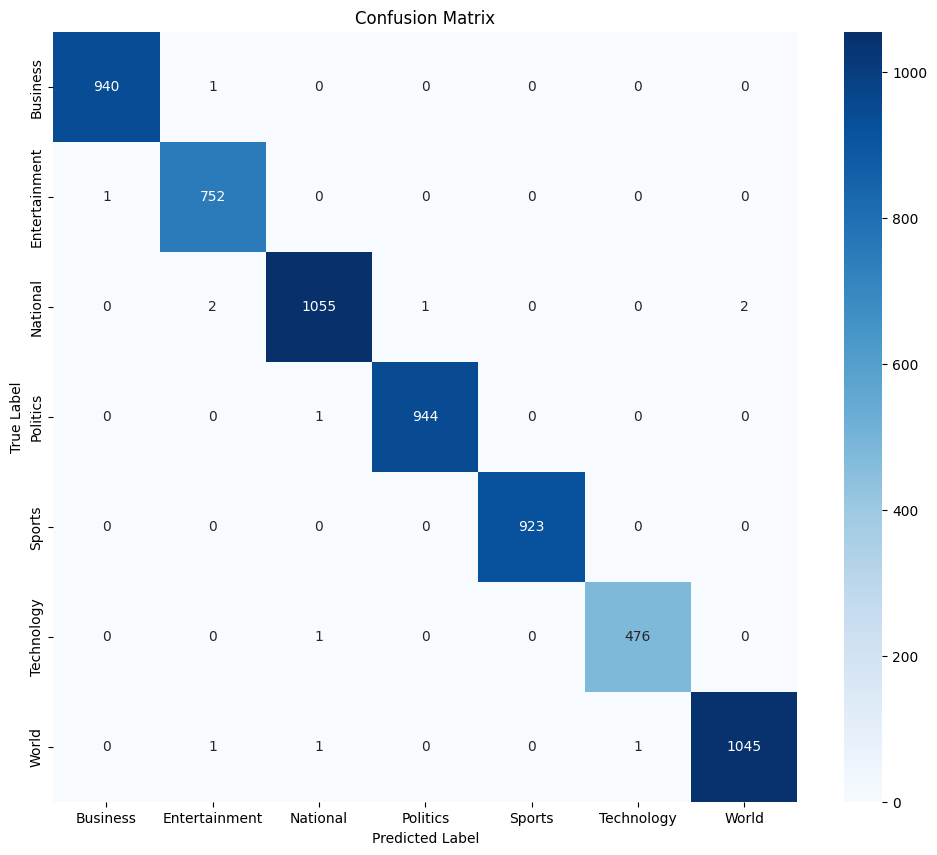


✅ Final Meta-Model Accuracy on Validation Set: 0.9980

📊 Base Model Accuracies on Meta Set:
CNN: 0.9979
LSTM: 0.9973
RNN: 0.9948


In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions from base models on the validation set
val_preds_all = [model.predict(X_val) for model in models_dict.values()]

# Stack predictions to create meta input
stacked_val_preds = np.concatenate(val_preds_all, axis=1)

# Meta model prediction
final_preds = meta_model.predict(stacked_val_preds)

# Convert one-hot labels and predictions to class indices
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(final_preds, axis=1)

# 🔹 Evaluation Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Final Accuracy
final_accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Final Meta-Model Accuracy on Validation Set: {final_accuracy:.4f}")

# 🔹 Base Model Accuracies
print("\n📊 Base Model Accuracies on Meta Set:")
for model_name, acc in model_accuracies.items():
    print(f"{model_name.upper()}: {acc:.4f}")

In [30]:
# Define the directory where you want to save models
save_dir = "/content/drive/MyDrive/MLModels"

import os
os.makedirs(save_dir, exist_ok=True)

# Save each model in .keras format to Google Drive
models_dict['cnn'].save(f"{save_dir}/cnn_model_sh.keras")
models_dict['lstm'].save(f"{save_dir}/lstm_model_sh.keras")
models_dict['rnn'].save(f"{save_dir}/rnn_model_sh.keras")
meta_model.save(f"{save_dir}/meta_model_sh.keras")

print("✅ All models saved successfully in .keras format to Google Drive!")

✅ All models saved successfully in .keras format to Google Drive!


In [33]:
import pickle

# Save the tokenizer
with open(f"{save_dir}/tokenizer_sh.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("Tokenizer saved successfully!")

Tokenizer saved successfully!


In [54]:
from tensorflow.keras.models import load_model
import pickle
import numpy as np

# Load the saved models
cnn_model = load_model("/content/drive/MyDrive/MLModels/cnn_model_sh.keras")
lstm_model = load_model("/content/drive/MyDrive/MLModels/lstm_model_sh.keras")
rnn_model = load_model("/content/drive/MyDrive/MLModels/rnn_model_sh.keras")
meta_model = load_model("/content/drive/MyDrive/MLModels/meta_model_sh.keras")

# Load the tokenizer
with open("/content/drive/MyDrive/MLModels/tokenizer_sh.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Load the label encoder
with open("/content/drive/MyDrive/MLModels/label_encoder_sh.pkl", "rb") as f:
    label_encoder = pickle.load(f)

print("Models, Tokenizer, and Label Encoder loaded successfully!")

Models, Tokenizer, and Label Encoder loaded successfully!


In [55]:
import re
import pandas as pd
import spacy
import json
nlp = spacy.blank("hi")  # blank model for tokenization
with open("/content/drive/MyDrive/news_dataset/stopwords-hi.json", "r", encoding="utf-8") as f:
    hindi_stopwords = set(json.load(f))

# Only remove non-Hindi characters and unwanted symbols
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # Remove only English letters, special symbols; keep Hindi and digits if needed
    text = re.sub(r'[a-zA-Z]', '', text)
    text = re.sub(r'[^\u0900-\u097F0-9\s]', '', text)  # Keep Hindi chars only
    text = re.sub(r'\s+', ' ', text).strip()
    #return text
# 2. Tokenizer using spaCy
    doc = nlp(text)
    tokens= [token.text for token in doc if token.text not in hindi_stopwords and token.text.strip() != ""]
    return " ".join(tokens)



In [56]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_category(headline):
    # Step 1: Preprocess the input headline
    headline = preprocess_text(headline)
    sequence = tokenizer.texts_to_sequences([headline])
    padded_sequence = pad_sequences(sequence, maxlen=200)

    # Step 2: Get predictions from base models
    cnn_pred = cnn_model.predict(padded_sequence)
    lstm_pred = lstm_model.predict(padded_sequence)
    rnn_pred = rnn_model.predict(padded_sequence)

    # Step 3: Stack predictions
    stacked_pred = np.concatenate([cnn_pred, lstm_pred, rnn_pred], axis=1)

    # Step 4: Meta-model final prediction
    final_pred = meta_model.predict(stacked_pred)

    # Step 5: Decode prediction
    predicted_class = label_encoder.inverse_transform([np.argmax(final_pred)])
    confidence = float(np.max(final_pred))

    return predicted_class[0], round(confidence, 3)


In [57]:
# Example headline
headline = "अमेरिका और चीन के बीच व्यापार समझौते पर फिर से बातचीत शुरू"

# Get the predicted category
category, conf=  predicted_category = predict_category(headline)

# Print the predicted category
print(f"The predicted category for the headline is: {predicted_category}({conf*100:.2f}% confidence)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
The predicted category for the headline is: ('World', 1.0)(100.00% confidence)
